In [ ]:
import tensorflow as tf
import numpy as np
import cv2
import os
import shutil
import glob
import zipfile

In [ ]:
from google.colab import drive

drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [ ]:
if not os.path.exists('content/paddy_disease/'):
  os.mkdir('/content/paddy_disease')
  print('content/paddy_disease is created')

content/paddy_disease is created


In [ ]:
try:
  shutil.copy('/content/gdrive/MyDrive/Colab Notebooks/paddy-disease-classification.zip', '/content/paddy_disease')

except Exception as e:
  print(e)

In [ ]:
with zipfile.ZipFile('/content/paddy_disease/paddy-disease-classification.zip' , 'r') as target_file:
  target_file.extractall('/content/paddy_disease')

**There are 10 classes in the given dataset.**

In [ ]:
base_path = '/content/paddy_disease/'
train_path = 'paddy-disease-classification/train_images/'

labels = os.listdir(base_path + train_path)

print(labels)

['dead_heart', 'bacterial_leaf_streak', 'tungro', 'hispa', 'blast', 'bacterial_panicle_blight', 'bacterial_leaf_blight', 'downy_mildew', 'brown_spot', 'normal']


Generate image data with keras ImageDataGenerator.


In [ ]:
img_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1.0/255.0,
    validation_split=0.15,
    rotation_range=15,
    shear_range=0.2,
    zoom_range=0.2,
    width_shift_range=0.05,
    height_shift_range=0.05,
    horizontal_flip=True,
    vertical_flip=True,
)

In [ ]:
train_gen = img_datagen.flow_from_directory(
    base_path + train_path,
    subset="training",
    seed=42,
    target_size=(128, 128),
    batch_size= 32,
    class_mode="categorical",
)

Found 8850 images belonging to 10 classes.


In [ ]:
valid_gen = img_datagen.flow_from_directory(
    base_path + train_path,
    subset="validation",
    seed=42,
    target_size=(128, 128),
    batch_size=32,
    class_mode="categorical",
)

Found 1557 images belonging to 10 classes.


Generate CNN model for training

In [ ]:
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import save_model, Sequential
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
model = Sequential()

model.add(Conv2D(input_shape = (128,128,3),
                 filters = 32,
                 kernel_size = (5,5),
                 padding = 'same',
                 activation = 'relu',
                 ))

model.add(MaxPool2D(pool_size = (2,2),
                    padding = 'same'))

model.add(Conv2D(filters = 64,
                 kernel_size = (4,4),
                 padding = 'same',
                 activation = 'relu',
                 ))


model.add(MaxPool2D(pool_size = (2,2),
                    padding = 'same'))


model.add(Conv2D(filters = 128,
                 kernel_size = (3,3),
                 padding = 'same',
                 activation = 'relu',
                 ))

model.add(MaxPool2D(pool_size = (2,2),
                    padding = 'same'))

model.add(Conv2D(filters = 256,
                 kernel_size = (3,3),
                 padding = 'same',
                 activation = 'relu',
                 ))

model.add(MaxPool2D(pool_size = (2,2),
                    padding = 'same'))

model.add(Dropout(0.25))

model.add(Flatten())

model.add(Dense(512, activation = 'relu'))
model.add(Dense(256, activation = 'relu'))
model.add(Dense(10, activation = 'softmax'))

model.compile(optimizer = Adam(), loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 32)      2432      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 64)        32832     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 32, 32, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 32, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 16, 16, 128)      0

In [ ]:
es = EarlyStopping(patience = 10, restore_best_weights = True)

hist = model.fit(train_gen, 
                 validation_data = valid_gen,
                 epochs = 100,
                 callbacks = [es])

Epoch 1/100
277/277 [==============================] - 97s 309ms/step - loss: 1.9966 - accuracy: 0.2869 - val_loss: 1.8243 - val_accuracy: 0.3481
Epoch 2/100
277/277 [==============================] - 85s 305ms/step - loss: 1.7280 - accuracy: 0.3920 - val_loss: 1.6919 - val_accuracy: 0.4072
Epoch 3/100
277/277 [==============================] - 86s 312ms/step - loss: 1.6046 - accuracy: 0.4360 - val_loss: 1.5163 - val_accuracy: 0.4740
Epoch 4/100
277/277 [==============================] - 84s 305ms/step - loss: 1.4949 - accuracy: 0.4716 - val_loss: 1.4420 - val_accuracy: 0.4984
Epoch 5/100
277/277 [==============================] - 84s 305ms/step - loss: 1.3678 - accuracy: 0.5288 - val_loss: 1.3898 - val_accuracy: 0.5318
Epoch 6/100
277/277 [==============================] - 84s 305ms/step - loss: 1.2634 - accuracy: 0.5627 - val_loss: 1.2122 - val_accuracy: 0.5954
Epoch 7/100
277/277 [==============================] - 84s 305ms/step - loss: 1.1354 - accuracy: 0.6185 - val_loss: 1.1088 -

In [ ]:
model.evaluate(valid_gen)

49/49 [==============================] - 12s 251ms/step - loss: 0.4073 - accuracy: 0.9056


[0.4072665572166443, 0.9055876731872559]

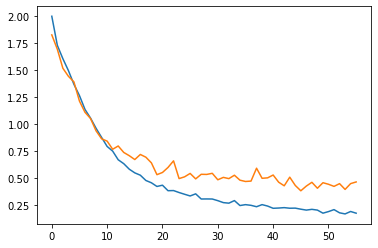

In [ ]:
import matplotlib.pyplot as plt

plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])

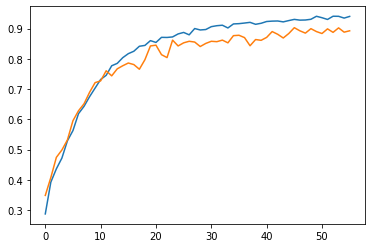

In [ ]:
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])

In [ ]:
from tensorflow.keras.models import save_model

save_model(model, 'paddy_disease_acc_90.h5')

In [ ]:
base_path = '/content/paddy_disease/'
test_path = 'paddy-disease-classification/test_images/'

imgs = []

test_imgs = glob.glob(base_path + test_path + "*")
for test_img in test_imgs:
  img = cv2.imread(test_img, cv2.IMREAD_COLOR)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  img = cv2.resize(img, dsize = (128,128))
  img = img/255.0

  imgs.append(img)


imgs = np.array(imgs)

predictions = model.predict(imgs.reshape(-1,128,128,3))

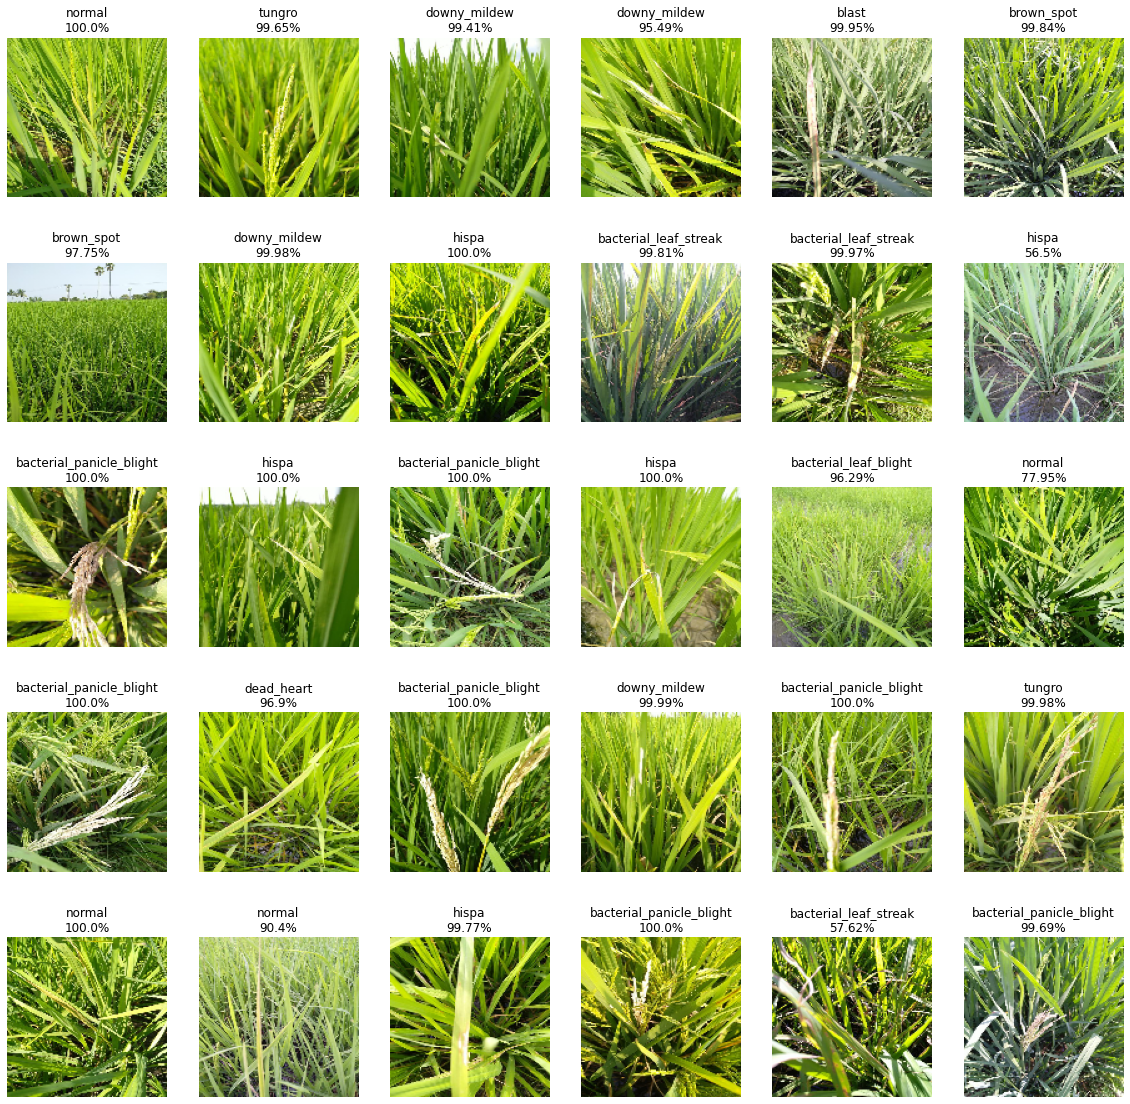

In [ ]:
top = 3 
plt.figure(figsize = (20,20))

for index in range(30):
  sorted_idx = predictions[index].argsort()
  sorted_idx = sorted_idx[::-1]

  plt.subplot(5,6, index+1)
  plt.axis('off')
  percent = round(predictions[index, sorted_idx[0]] * 100, 2)
  title = labels[sorted_idx[0]] + "\n"+ str(percent) + '%'
  plt.title(title)
  plt.imshow(imgs[index])
  
